In [1]:
import httpx
import asyncio
import pandas as pd
from pathlib import Path

## Baixa Merge

In [ ]:
url_base = 'https://ftp.cptec.inpe.br/modelos/tempo/MERGE/GPM/HOURLY'
diretorio = Path("horario")
limitador_tarefas = asyncio.Semaphore(7)

diretorio.mkdir(parents=True, exist_ok=True)

In [ ]:
inicio = "2019-08-13"
fim = "2023-12-31"

datas = pd.date_range(start=inicio, end=fim, freq="H").tolist()

In [ ]:
async def obter_merge(data: pd.Timestamp) -> None:
    """
    Baixa MERGE.

    Parameters
    ----------
    data : pd.Timestamp
        Timestamp
    """
    async with limitador_tarefas:
        async with httpx.AsyncClient() as cliente:
            arquivo = f'MERGE_CPTEC_{data.year}{data.strftime("%m")}{data.strftime("%d")}{data.strftime('%H')}.grib2'
            url_requisicao = (
                    f"{url_base}/{data.year}/{data.strftime("%m")}/{data.strftime("%d")}/{arquivo}"
                )
                
            resposta = await cliente.get(url_requisicao, timeout=30)
            await asyncio.sleep(2)

            if resposta.status_code == 200:
                conteudo = resposta.content
                diretorio_saida = Path(diretorio, arquivo)

                with open(diretorio_saida, "wb") as arquivo_:
                    arquivo_.write(conteudo)
                        
                print(f"{arquivo} [ok]")

            else:
                print(f"Não foi possível obter o {arquivo}.")
                print(url_requisicao)

In [ ]:
agendadas = set()

for data in datas:
    task = obter_merge(data)
    agendadas.add(task)

await asyncio.gather(*agendadas)

## Abre arquivo MERGE

In [2]:
import xarray as xr
import pandas as pd 
import rioxarray
import rasterio
from pathlib import Path
import geopandas as gpd
from tqdm import tqdm

## Funções

In [3]:
def set_lon180(
    da: xr.DataArray,
) -> xr.DataArray:
    """Ajusta a longitude de 0-360 para -180-180."""
    da = da.assign_coords(longitude=(((da.longitude + 180) % 360) - 180)).sortby("longitude")
    return da


def set_spatial_dims(
    da: xr.DataArray,
) -> xr.DataArray:
    """Define as dimensões espaciais de um DataArray Xarray."""
    da = da.rio.write_crs("EPSG:4674")
    da = da.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude")
    return da


def extract_data_utc(nome_arquivo: Path) -> pd.Timestamp:
    """Extrai datetime UTC do nome do arquivo."""
    nome = nome_arquivo.stem  # MERGE_CPTEC_YYYYMMDDHH
    return pd.to_datetime(nome.split("_")[-1], format="%Y%m%d%H")

In [4]:
caminho_merge_diario = Path("/home/rodrigocaldas/dados_tcc/MERGE/diario")
caminho_conceicao = Path("/home/rodrigocaldas/dados_tcc/sub-bacias-isoladas/tocantins/conceicao_do_araguaia.shp")
arquivos = sorted(caminho_merge_diario.glob("prec_diaria_brasilia_*.nc"))

In [5]:
gdf = gpd.read_file(caminho_conceicao)

if gdf.crs is None:
    gdf = gdf.set_crs("EPSG:4674")
    print("Setado")
else:
    gdf = gdf.to_crs("EPSG:4674")
    print("Transformado")

Setado


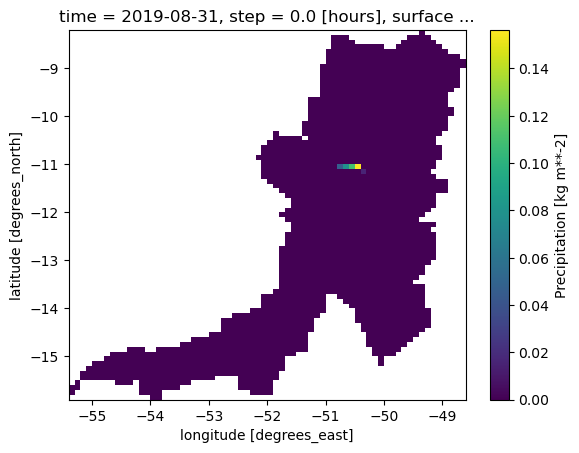

In [6]:
ds_1 = xr.open_dataset("/home/rodrigocaldas/dados_tcc/MERGE/diario/prec_diaria_brasilia_2019_08.nc", decode_timedelta=False)
ds_2 = xr.open_dataset("/home/rodrigocaldas/dados_tcc/MERGE/diario/prec_diaria_brasilia_2019_09.nc", decode_timedelta=False)

ds_1 = set_lon180(ds_1)
ds_1 = set_spatial_dims(ds_1)

ds_2 = set_lon180(ds_2)
ds_2 = set_spatial_dims(ds_2)

ds_1_recortado = ds_1.rio.clip(gdf.geometry, gdf.crs, drop=True)
ds_1_recortado["prec"].isel(time=19).plot()

In [7]:
ds_2_recortado = ds_2.rio.clip(gdf.geometry, gdf.crs, drop=True)
ds_1_recortado

<xarray.Dataset> Size: 420kB
Dimensions:      (latitude: 77, time: 20, longitude: 68)
Coordinates:
  * latitude     (latitude) float64 616B -15.85 -15.75 -15.65 ... -8.35 -8.25
  * time         (time) datetime64[ns] 160B 2019-08-12 2019-08-13 ... 2019-08-31
    step         float64 8B ...
    surface      float64 8B ...
  * longitude    (longitude) float64 544B -55.35 -55.25 -55.15 ... -48.75 -48.65
    spatial_ref  int64 8B 0
Data variables:
    prec         (time, latitude, longitude) float32 419kB nan nan ... nan nan
Attributes:
    GRIB_edition:            2
    GRIB_centre:             consensus
    GRIB_centreDescription:  Consensus
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             Consensus
    history:                 2025-06-21T21:04 GRIB to CDM+CF via cfgrib-0.9.1...

In [9]:
lista_df = []

for arquivo in arquivos:
    ds = xr.open_dataset(arquivo, decode_timedelta=False)
    ds = set_lon180(ds)
    ds = set_spatial_dims(ds)

    ds_recortado = ds.rio.clip(gdf.geometry, gdf.crs, drop=True)
    da = ds_recortado["prec"]

    soma_diaria = da.sum(dim=["latitude", "longitude"], skipna=True)
    media_diaria = da.mean(dim=["latitude", "longitude"], skipna=True)

    # Quantos pontos válidos existem por dia?
    validos_por_dia = da.notnull().sum(dim=["latitude", "longitude"])

    df_media_diaria = media_diaria.to_dataframe(name="media_prec").reset_index()
    df_media_diaria["soma_precipitacao"] = soma_diaria.values
    df_media_diaria["num_pontos_validos"] = validos_por_dia.values

    df_media_diaria.drop(columns=["step", "spatial_ref"], inplace=True)
    df_media_diaria.set_index("time", inplace=True)

    lista_df.append(df_media_diaria)

In [10]:
df = pd.concat(lista_df, axis=0).reset_index()
df

,time,surface,media_prec,soma_precipitacao,num_pontos_validos
0,2019-08-12,0.0,0.000000,0.000000,1931
1,2019-08-13,0.0,0.001262,2.437500,1931
2,2019-08-14,0.0,0.000000,0.000000,1931
3,2019-08-15,0.0,0.044856,86.617188,1931
4,2019-08-16,0.0,0.001367,2.640625,1931
...,...,...,...,...,...
1649,2023-12-26,0.0,0.630559,1217.609375,1931
1650,2023-12-27,0.0,2.532646,4890.539062,1931
1651,2023-12-28,0.0,5.060963,9772.718750,1931
1652,2023-12-29,0.0,2.234189,4314.218750,1931


In [11]:
resultado = df.groupby("time", as_index=False).agg({"media_prec": "mean", "soma_precipitacao": "sum", "num_pontos_validos": "first"})
resultado["media_prec_certa"] = resultado["soma_precipitacao"] / resultado["num_pontos_validos"]

In [ ]:
resultado.to_csv("valores_merge.csv")